# Standing Controller

## Load Basic Components

In [3]:
from typing import Callable
%matplotlib widget
%env MUJOCO_GL=egl

import pinocchio as pin
from dm_control import mujoco


import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import PIL.Image

import numpy as np
import pandas as pds
import os

env: MUJOCO_GL=egl


In [4]:
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")


# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

BASE_DIR = "/home/keseterg/Documents/Learning/robotics/control_demos"

Thu Mar 21 23:30:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off | 00000000:01:00.0  On |                  N/A |
| N/A   51C    P3               8W /  55W |    364MiB /  8188MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

/tmp/ipykernel_40963/2752404424.py:1: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.util


In [5]:
# Utility Function Collection
def get_model_path(pkg_name:str, name:str=None) -> str:
    if not name:
        name = pkg_name
    return os.path.join(BASE_DIR, "models", pkg_name, f"{name}.xml")

def get_model_dir(pkg_name) -> str:
    return os.path.join(BASE_DIR, "models", pkg_name)

def display_image(img_arr:np.array, size=[640,480]) -> PIL.Image:
    return PIL.Image.fromarray(img_arr).resize(size=size)

def render_motion(physics:mujoco.Physics, duration:float, 
                  framerate=60.0,
                  start_callback:Callable[[mujoco.Physics], None]=None,
                  step_callback:Callable[[mujoco.Physics], np.array]=None) -> None:
    frames = []

    physics.reset()
    if start_callback:
        start_callback(physics)
    while physics.data.time < duration:
        physics.step()
        
        if step_callback:
            u_torque = step_callback(physics)
            physics.data.ctrl = u_torque
        
        if len(frames) < framerate * physics.data.time:
            frames.append(physics.render())
            
    return display_video(frames=frames, framerate=framerate)

QUAL_HIGH = [640, 480]
QUAL_LOW = [320, 240]

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


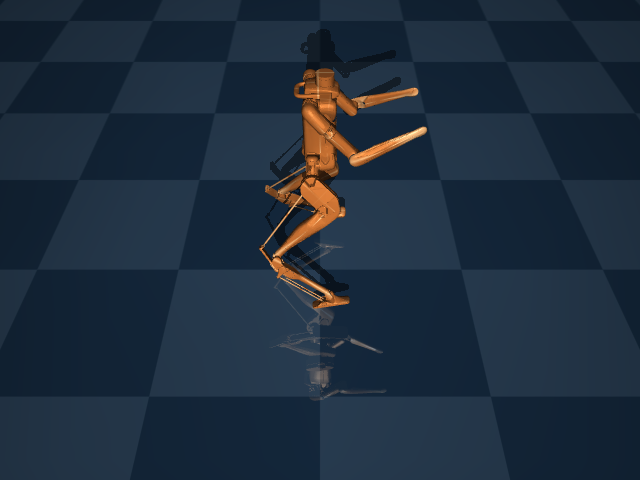

In [6]:
# load pinoccio and mujoco models
robot = pin.RobotWrapper.BuildFromURDF(
    os.path.join(
        get_model_dir("digit"), "urdf", "digit_float.urdf"
    ),
    package_dirs=[
        os.path.join(get_model_dir("digit"), "urdf")
    ],
    root_joint=pin.JointModelFreeFlyer()
)

# Initialize the viewer in MeshCat.
pin_viz = pin.visualize.MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
pin_viz.initViewer()
pin_viz.loadViewerModel("pinocchio")



physics = mujoco.Physics.from_xml_path(get_model_path("digit", "digit-v3"))
display_image(
    physics.render(width=QUAL_HIGH[0], height=QUAL_HIGH[1]), size=QUAL_HIGH
)

In [9]:
q_0 = pin.neutral(robot.model)
qd_0 = np.zeros(robot.model.nv)
pin_viz.display(q_0)
_ = robot.computeJointJacobians(q_0)
J_c = robot.getJointJacobian(robot.model.getJointId("toe_pitch_joint_left"), pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
pin.forwardKinematics(robot.model, robot.data, q_0, qd_0)
pin.updateFramePlacements(robot.model, robot.data)

for i in [6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26]:
    print(robot.model)
    print(robot.model.names[i])

Nb joints = 24 (nq=29,nv=28)
  Joint 0 universe: parent=0
  Joint 1 root_joint: parent=0
  Joint 2 hip_abduction_left: parent=1
  Joint 3 hip_rotation_left: parent=2
  Joint 4 hip_flexion_left: parent=3
  Joint 5 knee_joint_left: parent=4
  Joint 6 shin_to_tarsus_left: parent=5
  Joint 7 toe_pitch_joint_left: parent=6
  Joint 8 toe_roll_joint_left: parent=7
  Joint 9 hip_abduction_right: parent=1
  Joint 10 hip_rotation_right: parent=9
  Joint 11 hip_flexion_right: parent=10
  Joint 12 knee_joint_right: parent=11
  Joint 13 shin_to_tarsus_right: parent=12
  Joint 14 toe_pitch_joint_right: parent=13
  Joint 15 toe_roll_joint_right: parent=14
  Joint 16 shoulder_roll_joint_left: parent=1
  Joint 17 shoulder_pitch_joint_left: parent=16
  Joint 18 shoulder_yaw_joint_left: parent=17
  Joint 19 elbow_joint_left: parent=18
  Joint 20 shoulder_roll_joint_right: parent=1
  Joint 21 shoulder_pitch_joint_right: parent=20
  Joint 22 shoulder_yaw_joint_right: parent=21
  Joint 23 elbow_joint_right:

IndexError: Index out of range

In [78]:
for i in robot.model.names:
    print(i)

universe
root_joint
hip_abduction_left
hip_rotation_left
hip_flexion_left
knee_joint_left
shin_to_tarsus_left
toe_pitch_joint_left
toe_roll_joint_left
hip_abduction_right
hip_rotation_right
hip_flexion_right
knee_joint_right
shin_to_tarsus_right
toe_pitch_joint_right
toe_roll_joint_right
shoulder_roll_joint_left
shoulder_pitch_joint_left
shoulder_yaw_joint_left
elbow_joint_left
shoulder_roll_joint_right
shoulder_pitch_joint_right
shoulder_yaw_joint_right
elbow_joint_right


In [79]:
robot.model.names

In [80]:
print("Basic Robot Info:")
print(robot.model)
print(
    pin.computeGeneralizedGravity(
        robot.model, robot.data, pin.neutral(robot.model)
    ).shape
)

Basic Robot Info:
Nb joints = 24 (nq=29,nv=28)
  Joint 0 universe: parent=0
  Joint 1 root_joint: parent=0
  Joint 2 hip_abduction_left: parent=1
  Joint 3 hip_rotation_left: parent=2
  Joint 4 hip_flexion_left: parent=3
  Joint 5 knee_joint_left: parent=4
  Joint 6 shin_to_tarsus_left: parent=5
  Joint 7 toe_pitch_joint_left: parent=6
  Joint 8 toe_roll_joint_left: parent=7
  Joint 9 hip_abduction_right: parent=1
  Joint 10 hip_rotation_right: parent=9
  Joint 11 hip_flexion_right: parent=10
  Joint 12 knee_joint_right: parent=11
  Joint 13 shin_to_tarsus_right: parent=12
  Joint 14 toe_pitch_joint_right: parent=13
  Joint 15 toe_roll_joint_right: parent=14
  Joint 16 shoulder_roll_joint_left: parent=1
  Joint 17 shoulder_pitch_joint_left: parent=16
  Joint 18 shoulder_yaw_joint_left: parent=17
  Joint 19 elbow_joint_left: parent=18
  Joint 20 shoulder_roll_joint_right: parent=1
  Joint 21 shoulder_pitch_joint_right: parent=20
  Joint 22 shoulder_yaw_joint_right: parent=21
  Joint 23 

In [81]:
print(robot.model.nq)
print(physics.model.nu)

29
20


In [82]:
q_delta = 5
qd_delta = 4

def mj_to_pin_q(q:np.array) -> np.array:
    result = np.zeros(robot.nq)
    
    # copy floating joint
    result[0:3] = q[0:3].copy()
    result[3] = q[4]
    result[4] = q[5]
    result[5] = q[6]
    result[6] = q[3]
    
    # copy the corresponding joints
    result[2+q_delta]  = q[7]
    result[3+q_delta]  = q[8]
    result[4+q_delta]  = q[9]
    result[5+q_delta]  = q[14]
    result[6+q_delta]  = q[15]
    result[7+q_delta]  = q[15]
    result[8+q_delta]  = q[15]
    result[9+q_delta]  = q[34]
    result[10+q_delta] = q[35]
    result[11+q_delta] = q[36]
    result[12+q_delta] = q[41]
    result[13+q_delta] = q[42]
    result[14+q_delta] = q[45]
    result[15+q_delta] = q[50]
    result[16+q_delta] = q[30]
    result[17+q_delta] = q[31]
    result[18+q_delta] = q[32]
    result[19+q_delta] = q[33]
    result[20+q_delta] = q[57]
    result[21+q_delta] = q[58]
    result[22+q_delta] = q[59]
    result[23+q_delta] = q[60]
    
    return result

def mj_to_pin_qd(q:np.array) -> np.array:
    result = np.zeros(robot.nv)
    
    # copy floating joint
    result[0:6] = q[0:6].copy()
    
    # copy the corresponding joints
    result[2+qd_delta]  = q[6]
    result[3+qd_delta]  = q[7]
    result[4+qd_delta]  = q[8]
    result[5+qd_delta]  = q[12]
    result[6+qd_delta]  = q[13]
    result[7+qd_delta]  = q[16]
    result[8+qd_delta]  = q[20]
    result[9+qd_delta]  = q[30]
    result[10+qd_delta] = q[31]
    result[11+qd_delta] = q[12]
    result[12+qd_delta] = q[36]
    result[13+qd_delta] = q[37]
    result[14+qd_delta] = q[40]
    result[15+qd_delta] = q[44]
    result[16+qd_delta] = q[26]
    result[17+qd_delta] = q[27]
    result[18+qd_delta] = q[28]
    result[19+qd_delta] = q[29]
    result[20+qd_delta] = q[50]
    result[21+qd_delta] = q[51]
    result[22+qd_delta] = q[52]
    result[23+qd_delta] = q[53]
    
    return result
    

In [83]:
def pinocchio_update(physics:mujoco.Physics) -> None:
    physics.forward()
    q = mj_to_pin_q(physics.data.qpos)
    qd = mj_to_pin_qd(physics.data.qvel)
    qdd = mj_to_pin_qd(physics.data.qacc_smooth)
    robot.forwardKinematics(q, qd, qdd)
    return q, qd, qdd

## Falling Process and Centroid Dynamics

In [84]:
T

NameError: name 'T' is not defined

In [ ]:
render_motion(physics=physics, duration=5.0, framerate=60.)

In [ ]:
# testing that the obe
def random_control(physics:mujoco.Physics) -> np.array:
    return np.random.randn(physics.model.nu)
render_motion(physics=physics,duration=5, framerate=60, step_callback=random_control)

In [ ]:
p_MCoM_M = []
h_Des = 0.90
r_Des = 0.0
y_Des = 0.0
x_Des = 0.0

kP_c = 0.1
kD_c = 0.1
kP_h = 0.1
kD_h = 0.1

kP_jnt = 0.1
kD_jnt = 0.1

def basic_standing_control(physics:mujoco.Physics) -> np.array:
    q, qd, qdd = pinocchio_update(physics)
    pin.jacobianCenterOfMass(robot.model, robot.data)
    Quat_WP_W = pin.Quaternion(q[3:7])

    R_WP_W = Quat_WP_W.toRotationMatrix()
    # constraint: hip flexion and shin are the same (pos 2, 4; pos 9, 11)
    
    q_Des = np.zeros(physics.model.nu)
    tau_Des = np.zeros(physics.model.nu)

    # caluclate center of mass position w.r.t. middle frame
    p_WCoM_W = robot.data.com[0]
    p_WM_W = (
        robot.data.oMi[robot.model.getFrameId("toe_pitch_joint_left")].translation
        + robot.data.oMf[robot.model.getFrameId("toe_pitch_joint_right")].translation
    ) / 2.0
    p_MCoM_W = -p_WM_W + p_WCoM_W
    p_MCoM_W_Des = np.array([x_Des, y_Des, h_Des])
    p_MCom_W_Delta = p_MCoM_W - p_MCoM_W_Des
    v_Com = qd[0:3]
    
    # feedback on leg height based on CoM pos and vel
    lateral_shift = p_MCom_W_Delta[1]
    height_shift = p_MCom_W_Delta[2]
    left_tune = kP_c * lateral_shift + kD_c * v_Com[1]
    right_tune = -left_tune
    height_tune = -kP_h * height_shift * -kD_h * v_Com[2]
    
    # calculate torque based on PD control law
    
    
    return tau_Des
    
    
render_motion(physics=physics, duration=5, framerate=60, step_callback=basic_standing_control)
    

In [ ]:
physics.model.nu

In [ ]:
pin.Quaternion(np.array([1,0,0,0]))

In [ ]:

print(len(robot.data.v))
print(robot.model.nv)